## Advanced DL and RL: Домашнее задание 1

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py

In [1]:
import gym
import sys
import random
import numpy as np
import scipy as sp
from collections import defaultdict
from tqdm import tqdm
from operator import mul
from functools import reduce

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Часть первая, с блекджеком и стратегиями

In [2]:
env = gym.make('Blackjack-v0', natural=True)

In [3]:
env.reset()
for _ in range(5):
    observation, reward, done, info = env.step(env.action_space.sample())
    print(observation, reward, done)
    
env.close()

(18, 3, False) 1.0 True
(20, 3, False) 0.0 False
(22, 3, False) -1.0 True
(22, 3, False) 0.0 True
(22, 3, False) 0.0 True


1. Рассмотрим очень простую стратегию: говорить `stand`, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить `hit`. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [4]:
EPISODES = 200000

In [5]:
class NaiveStrategy:
    def __call__(self, observation, training=False):
        return 0 if observation[0] > 18 else 1 

In [6]:
def one_episode(env, pi, training=False):
    observation = env.reset()
    
    rewards = []
    done = False
    while not done:
        action = pi(observation, training)
        next_observation, reward, done, info = env.step(action)
        if training:
            pi.update_Q(observation, action, reward, next_observation)
        observation = next_observation
        rewards.append(reward)

    return rewards

def evaluate_strategy(env, pi, total_episodes, verbose=True):
    total_reward = 0.
    for i_episode in range(1, total_episodes + 1):
        if verbose:
            if i_episode % 100 == 0:
                print("\rEpisode {}/{}".format(i_episode, total_episodes), end="")
                sys.stdout.flush()
        rewards = one_episode(env, pi)         
        total_reward = total_reward + rewards[-1]  
    mean_reward = total_reward / total_episodes      
        
    return mean_reward

In [7]:
naive_pi = NaiveStrategy()
avg_naive_reward = evaluate_strategy(env, naive_pi, EPISODES)
env.close()

Episode 200000/200000

In [8]:
print("Оценка среднего выигрыша для наивной стратегии составит: {0}".format(avg_naive_reward))

Оценка среднего выигрыша для наивной стратегии составит: -0.18238


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение `Blackjack-v0` из OpenAI Gym.

In [9]:
class QLearningStrategy:
    def __init__(self, env, alpha, gamma, eps):
        self.__env = env
        self.__n_actions = env.action_space.n
        self.__Q = defaultdict(lambda: np.zeros(self.__n_actions)) 
        self.__alpha = alpha
        self.__gamma = gamma
        self.__eps = eps
        
    def __call__(self, observation, training=False):
        if random.random() > self.__eps or not training:
            return np.argmax(self.__Q[observation])
        else:
            return np.random.choice(np.arange(self.__n_actions))
        
    def update_Q(self, observation, action, reward, next_observation):
        current_Q = self.__Q[observation][action]
        next_Q = np.max(self.__Q[next_observation]) if next_observation is not None else 0
        target_Q = reward + (self.__gamma * next_Q)
        self.__Q[observation][action] = current_Q + self.__alpha * (target_Q - current_Q)

In [10]:
def q_learning_train(env, pi, total_episodes):
    rewards = []
    trends = []
    for i_episode in range(0, total_episodes):
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode + 100, total_episodes), end="")
            sys.stdout.flush()
        observation = env.reset()    
        rewards.append(one_episode(env, pi, True)) 
        
        if i_episode % 10000 == 0:
            trends.append((i_episode, evaluate_strategy(env, pi, 10000, False)))
            
    return pi, rewards, trends

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [11]:
def plot_reward(data, label):
    plt.plot([x[0] for x in data], [y[1] for y in data], label=label)
    plt.ylim([-0.4, 0.1])
    plt.xlabel('Episode')
    plt.ylabel('Avg. reward')
    plt.grid()
    plt.legend(loc='lower right')

In [12]:
env = gym.make('Blackjack-v0', natural=True)
alpha = 1e-05
gamma = .95
eps = 0.9
EPISODES = 200000

In [13]:
pi = QLearningStrategy(env, alpha, gamma, eps)
q_learning_pi, training_rewards, plot_data = q_learning_train(env, pi, EPISODES)

Episode 200000/200000

In [14]:
avg_q_learning_reward = evaluate_strategy(env, q_learning_pi, EPISODES)

Episode 200000/200000

In [15]:
print("Оценка среднего выигрыша для Q-learning стратегии составит: {0}".format(avg_q_learning_reward))

Оценка среднего выигрыша для Q-learning стратегии составит: -0.0314575


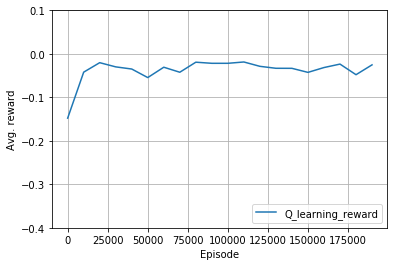

In [16]:
plot_reward(plot_data, "Q_learning_reward")

In [17]:
env.close()

### Часть вторая, удвоенная

4. Реализуйте новый вариант блекджека на основе окружения `Blackjack-v0` из OpenAI Gym, в котором разрешено удвоение ставки.

Новый вариант блекджека на основе окружения `Blackjack-v0` из OpenAI Gym, в котором разрешено удвоение ставки, реализован в файле `blackjack_double.py`

In [18]:
import blackjack_double

In [19]:
env_double = blackjack_double.BlackjackEnv(natural=True)
alpha = 1e-05
gamma = .95
eps = 0.9
EPISODES = 200000

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.3.

In [20]:
pi_double = QLearningStrategy(env_double, alpha, gamma, eps)
q_learning_pi_double, training_rewards_double, plot_data_double = \
    q_learning_train(env_double, pi_double, EPISODES)

Episode 200000/200000

In [21]:
avg_q_learning_double_reward = evaluate_strategy(env_double, q_learning_pi_double, EPISODES)

Episode 200000/200000

In [22]:
print("Оценка среднего выигрыша для Q-learning стратегии с возможностью удваивания составит: {0}" \
      .format(avg_q_learning_double_reward))

Оценка среднего выигрыша для Q-learning стратегии с возможностью удваивания составит: -0.0222


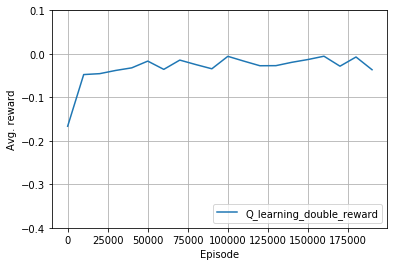

In [23]:
#plot_reward(plot_data, "Q_learning_reward")
plot_reward(plot_data_double, "Q_learning_double_reward")

In [24]:
env_double.close()

### Часть третья, в главной роли — Дастин Хоффман

6. Реализуйте вариант окружения `Blackjack-v0` из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

Обновленный вариант блекджека с удвоением, в котором игрок имеет возможность “считать карты” в колоде, реализован в файле `blackjack_counter.py`. Подсчет карт реализован <b>по системе "Плюс-минус"</b>.

In [25]:
import blackjack_counter

In [26]:
env_cnt = blackjack_counter.BlackjackEnv(natural=True)
alpha = 1e-05
gamma = .95
eps = 0.9
EPISODES = 1000000

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.3.

In [27]:
pi_cnt = QLearningStrategy(env_cnt, alpha, gamma, eps)
q_learning_pi_cnt, training_rewards_cnt, plot_data_cnt = \
    q_learning_train(env_cnt, pi_cnt, EPISODES)

Episode 1000000/1000000

In [28]:
avg_q_learning_cnt_reward = evaluate_strategy(env_cnt, q_learning_pi_cnt, EPISODES)

Episode 1000000/1000000

In [29]:
print("Оценка среднего выигрыша для Q-learning стратегии с возможностью удваивания и системой подсчета карт 'Плюс-минус' составит: {0}" \
      .format(avg_q_learning_cnt_reward))

Оценка среднего выигрыша для Q-learning стратегии с возможностью удваивания и системой подсчета карт 'Плюс-минус' составит: -0.0072155


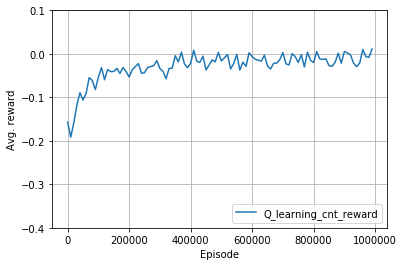

In [30]:
plot_reward(plot_data_cnt, "Q_learning_cnt_reward")

In [31]:
env_cnt.close()

<b>Выводы:</b>
1. Реализованы стратегии игры в блекджек с последовательным добавлением дополнительных возможностей - базовая, с удвоением и подсчетом карт. 
2. Каждый следующий вариант позволил увеличить средний ожидаемый выигрыш, однако обыграть казино так и не удалось. Наилучший средний выигрыш составил <b>-0.0072155</b>. Из полученных графиков видно, что мы вплотную подобрались к "нулевой отметке", а в отдельных случаях даже добиваемся положительного результата. 
3. На пункты 8 (уравнение Беллмана) и 9 (реализация `split`) не хватило времени.